In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [52]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [53]:
words = open('names.txt', 'r').read().splitlines()

In [54]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [71]:
block_size = 4
embedding_dim = 16
vocab_size = len(chars)
hidden_dim = 256
batch_size = 64

In [72]:
def bulid_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = bulid_dataset(words[:n1])
Xval, Yval = bulid_dataset(words[n1:n2])
Xte, Yte = bulid_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [86]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embedding_dim), generator=g) # two dimensional embedding
W1 = torch.randn((embedding_dim*block_size, hidden_dim), generator=g)
b1 = torch.randn((hidden_dim), generator=g)
W2 = torch.randn((hidden_dim, hidden_dim), generator=g)
b2 = torch.randn((hidden_dim), generator=g)
W3 = torch.randn((hidden_dim, vocab_size), generator=g)
b3 = torch.randn((vocab_size), generator=g)
parameters = [C, W1, b1, W2, b2, W3, b3]
for p in parameters:
    p.requires_grad = True

In [87]:
print(f"{sum(p.nelement() for p in parameters)} parameters")

89803 parameters


In [88]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [89]:
lossei = []
stepi = []
lri = []

In [90]:
for i in range(200000):
    # make a mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    h1 = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    logits = h2 @ W3 + b3 # (32,100) @ (100, 27) + (27) -> (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    lossei.append(loss.item())
    stepi.append(i)

    # update
    # Implement learning rate decay using a cosine annealing schedule
    max_iterations = 200000  # Total number of iterations
    initial_lr = 0.1
    min_lr = 0.001
    lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(math.pi * i / max_iterations))
    for p in parameters:
        p.data -= lr * p.grad
    
    lossei.append(loss.log10().item())
    stepi.append(i)
    lri.append(lr)


KeyboardInterrupt: 

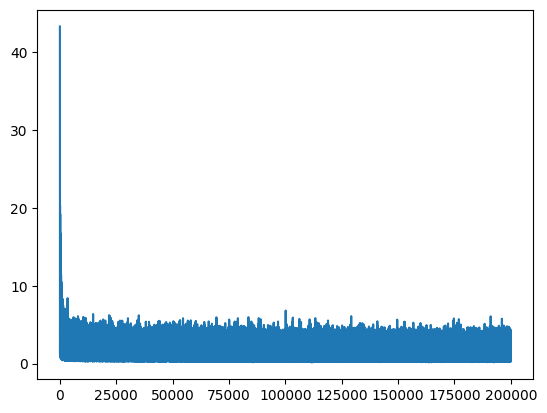

In [80]:
plt.plot(stepi, lossei)
plt.show()

In [81]:
print(loss.item())


2.928765058517456


In [83]:
emb = C[Xval]
h1 = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3
loss = F.cross_entropy(logits, Yval)
print(loss.item())


2.8463134765625


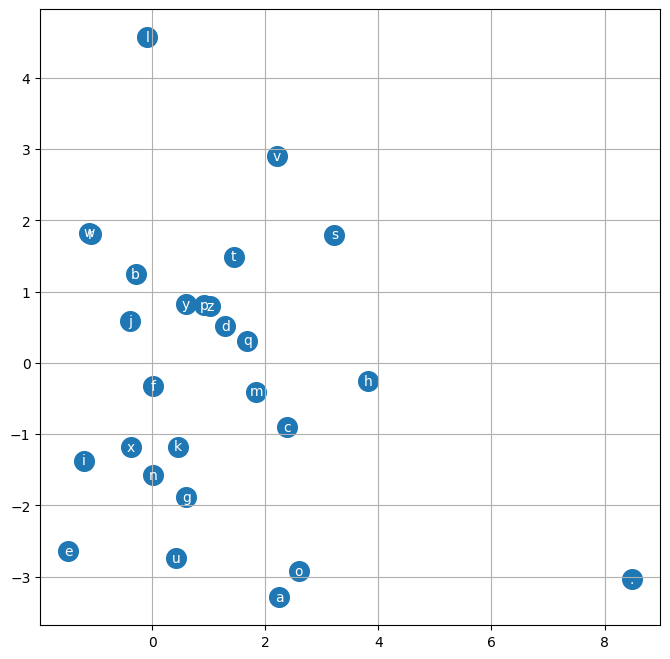

In [84]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), decode(i), ha='center', va='center', color='white')
plt.grid("minor")

In [ ]:
# train, validation, test split
# 80/10/10 split
